# Hazardous Chemicals in Cosmetics

In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the data set
input_data = "Resources/cosmetics_data.csv"
cosmetics_df = pd.read_csv(input_data, low_memory=False)
cosmetics_df.head(1)

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,13463-67-7,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1


- DATA CLEANING

In [3]:
# Remove unnecessary columns
columns_to_drop = ["CDPHId", "CSFId", "CompanyId", "PrimaryCategoryId", "SubCategoryId", "CasId", "ChemicalId"]
cosmetics_cleaned_df = cosmetics_df.drop(columns=columns_to_drop)
cosmetics_cleaned_df.head(1)

,ProductName,CSF,CompanyName,BrandName,PrimaryCategory,SubCategory,CasNumber,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,New Avon LLC,AVON,Makeup Products (non-permanent),"Lip Color - Lipsticks, Liners, and Pencils",13463-67-7,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1


In [4]:
# Change dates to datetime objects
cosmetics_cleaned_df["InitialDateReported"] = pd.to_datetime(cosmetics_cleaned_df["InitialDateReported"])
cosmetics_cleaned_df["MostRecentDateReported"] = pd.to_datetime(cosmetics_cleaned_df["MostRecentDateReported"])
cosmetics_cleaned_df["DiscontinuedDate"] = pd.to_datetime(cosmetics_cleaned_df["DiscontinuedDate"])
cosmetics_cleaned_df["ChemicalCreatedAt"] = pd.to_datetime(cosmetics_cleaned_df["ChemicalCreatedAt"])
cosmetics_cleaned_df["ChemicalUpdatedAt"] = pd.to_datetime(cosmetics_cleaned_df["ChemicalUpdatedAt"])
cosmetics_cleaned_df["ChemicalDateRemoved"] = pd.to_datetime(cosmetics_cleaned_df["ChemicalDateRemoved"])
cosmetics_cleaned_df.head(1)

,ProductName,CSF,CompanyName,BrandName,PrimaryCategory,SubCategory,CasNumber,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,New Avon LLC,AVON,Makeup Products (non-permanent),"Lip Color - Lipsticks, Liners, and Pencils",13463-67-7,Titanium dioxide,2009-06-17,2013-08-28,2011-02-01,2009-07-09,2009-07-09,NaT,1


In [5]:
# Check shape
cosmetics_cleaned_df.shape

(114635, 15)

In [6]:
# Check for duplicates
print(cosmetics_cleaned_df.duplicated().sum())

7701


In [7]:
# Drop duplicates and check shape again
cosmetics_cleaned_df = cosmetics_cleaned_df.drop_duplicates()
cosmetics_cleaned_df.shape

(106934, 15)

In [8]:
# Filter the dataset where the 'CasId' is missing (NaN)
missing_cas_df = cosmetics_cleaned_df[cosmetics_cleaned_df['CasNumber'].isna()]

# Select relevant columns like 'ChemicalName' and 'CasId' to inspect
missing_cas_df = missing_cas_df[['ChemicalName', 'CasNumber']]

# Select only the unique chemical names with missing CAS numbers
unique_missing_cas_df = missing_cas_df[['ChemicalName']].drop_duplicates()

# Group by 'ChemicalName' and count occurrences
missing_cas_count_df = missing_cas_df.groupby('ChemicalName').size().reset_index(name='Count')

# Merge the two DataFrames on 'ChemicalName'
missing_cas_chemicals_df = pd.merge(unique_missing_cas_df, missing_cas_count_df, on='ChemicalName', how='inner')

# Sort by the count column (assuming the count column is named 'Count')
missing_cas_chemicals_df = missing_cas_chemicals_df.sort_values(by='Count', ascending=False)
missing_cas_chemicals_df.head()

,ChemicalName,Count
4,"Silica, crystalline (airborne particles of res...",2461
9,Retinyl palmitate,1063
2,"Retinol/retinyl esters, when in daily dosages ...",682
11,"Mineral oils, untreated and mildly treated",510
12,Cocamide DEA,234


In [9]:
# Standardize name for all retinyl esters
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Retinyl palmitate", "ChemicalName"] = "Retinyl esters"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.", "ChemicalName"] = "Retinyl esters"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Retinyl acetate", "ChemicalName"] = "Retinyl esters"

In [10]:
# Standardize name for titanium dioxide
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Titanium dioxide (airborne, unbound particles of respirable size)", "ChemicalName"] = "Titanium dioxide"

In [11]:
# Standardize name for talc
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Cosmetic talc", "ChemicalName"] = "Talc"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Talc (powder)", "ChemicalName"] = "Talc"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Talc containing asbestiform fibers", "ChemicalName"] = "Talc"

In [12]:
# Standardize name for cocamide DEA
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Cocamide diethanolamine", "ChemicalName"] = "Cocamide DEA"

# 1. Which companies and brands have the most reports of potentially hazardous chemicals?

In [13]:
# Group data by company name and chemical counts
companies_df = cosmetics_cleaned_df.groupby(["CompanyName", "ChemicalName"])["ChemicalName"].count().reset_index(name="ChemicalCount")
sorted_companies_df = companies_df.sort_values(by='ChemicalCount', ascending=False)
sorted_companies_df.head(20)

,CompanyName,ChemicalName,ChemicalCount
709,L'Oreal USA,Titanium dioxide,5711
1226,S+,Titanium dioxide,3900
334,Coty,Titanium dioxide,3700
149,"Bare Escentuals Beauty, Inc.",Titanium dioxide,3674
1366,The Procter & Gamble Company,Titanium dioxide,3344
1186,Revlon Consumer Product Corporation,Titanium dioxide,2997
1331,Tarte Cosmetics,Titanium dioxide,2381
942,Nars Cosmetics,Titanium dioxide,1987
80,American International Industries,Titanium dioxide,1755
1453,Victoria's Secret Beauty,Titanium dioxide,1702


In [14]:
# Put the top 20 in their own data frame
top20_companies_df = sorted_companies_df[sorted_companies_df['ChemicalCount'] >= 1021]
top20_companies_df

,CompanyName,ChemicalName,ChemicalCount
709,L'Oreal USA,Titanium dioxide,5711
1226,S+,Titanium dioxide,3900
334,Coty,Titanium dioxide,3700
149,"Bare Escentuals Beauty, Inc.",Titanium dioxide,3674
1366,The Procter & Gamble Company,Titanium dioxide,3344
1186,Revlon Consumer Product Corporation,Titanium dioxide,2997
1331,Tarte Cosmetics,Titanium dioxide,2381
942,Nars Cosmetics,Titanium dioxide,1987
80,American International Industries,Titanium dioxide,1755
1453,Victoria's Secret Beauty,Titanium dioxide,1702


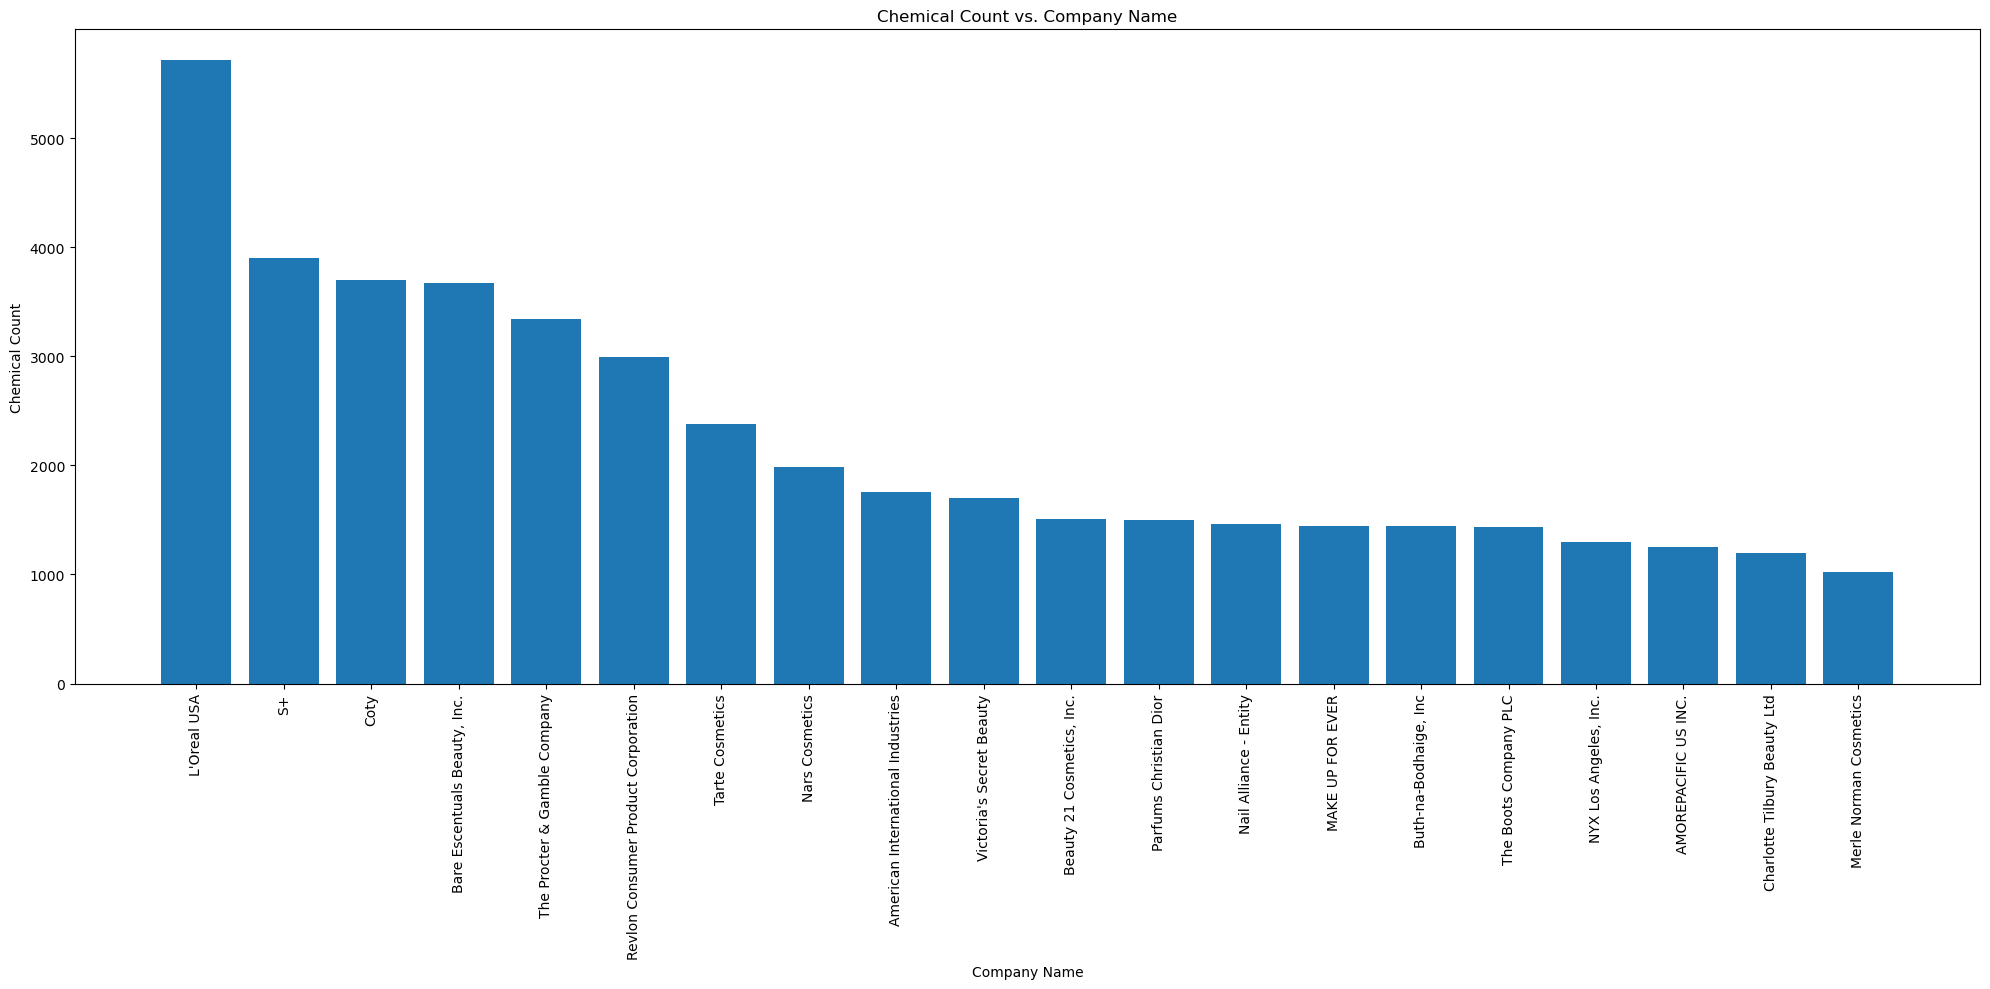

In [18]:
# Plotting the data
plt.figure(figsize=(20,10))

plt.bar(top20_companies_df["CompanyName"], top20_companies_df["ChemicalCount"])

plt.xlabel('Company Name')
plt.ylabel('Chemical Count')
plt.title('Chemical Count vs. Company Name')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Graphs/graph1.png")
plt.show()

In [19]:
# Group data by brand name and chemical counts
brands_df = cosmetics_cleaned_df.groupby(["BrandName", "ChemicalName"])["ChemicalName"].count().reset_index(name="ChemicalCount")
sorted_brands_df = brands_df.sort_values(by="ChemicalCount", ascending=False)
sorted_brands_df.head(20)

,BrandName,ChemicalName,ChemicalCount
4124,bareMinerals,Titanium dioxide,3031
3175,SEPHORA,Titanium dioxide,2257
4219,tarte,Titanium dioxide,2021
2509,NARS,Titanium dioxide,1982
3090,Revlon,Titanium dioxide,1747
3320,Sephora,Titanium dioxide,1639
3945,Victoria's Secret Beauty,Titanium dioxide,1594
1052,CoverGirl,Titanium dioxide,1584
2818,Parfums Christian Dior,Titanium dioxide,1477
2258,MAKE UP FOR EVER,Titanium dioxide,1444


In [20]:
# Put the top 20 brands in their own data frame
top20_brands_df = sorted_brands_df[sorted_brands_df["ChemicalCount"] >= 989]
top20_brands_df

,BrandName,ChemicalName,ChemicalCount
4124,bareMinerals,Titanium dioxide,3031
3175,SEPHORA,Titanium dioxide,2257
4219,tarte,Titanium dioxide,2021
2509,NARS,Titanium dioxide,1982
3090,Revlon,Titanium dioxide,1747
3320,Sephora,Titanium dioxide,1639
3945,Victoria's Secret Beauty,Titanium dioxide,1594
1052,CoverGirl,Titanium dioxide,1584
2818,Parfums Christian Dior,Titanium dioxide,1477
2258,MAKE UP FOR EVER,Titanium dioxide,1444


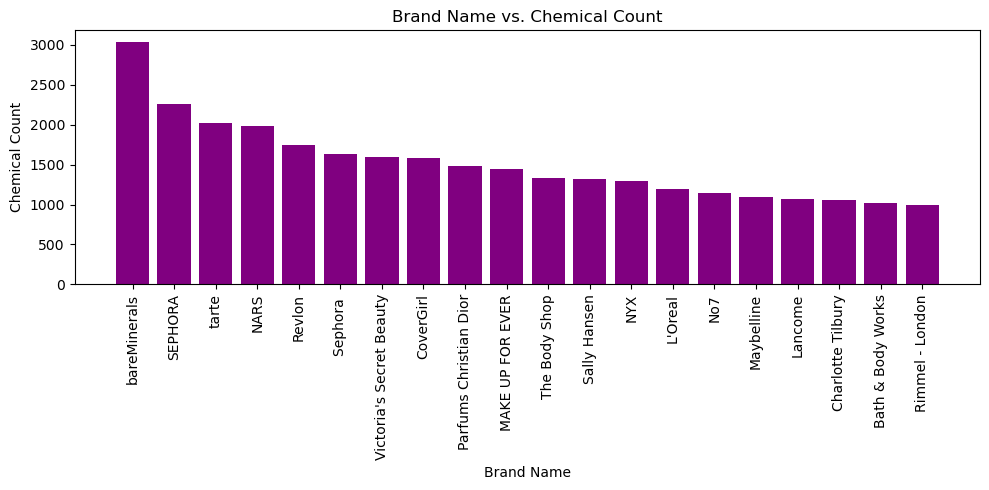

In [21]:
# Plotting the data
plt.figure(figsize=(10,5))

plt.bar(top20_brands_df["BrandName"], top20_brands_df["ChemicalCount"], color="purple")

plt.xlabel('Brand Name')
plt.ylabel('Chemical Count')
plt.title('Brand Name vs. Chemical Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Graphs/graph2.png")

plt.show()

In [22]:
# Check company chemical reports, not including titanium dioxide
not_titanium_reports_df = cosmetics_cleaned_df.groupby(["CompanyName", "ChemicalName"])["ChemicalName"].count().reset_index(name="ChemicalCount")
rmv_titanuim_df = not_titanium_reports_df.loc[not_titanium_reports_df["ChemicalName"] != "Titanium dioxide"]
sorted_rmv_titanuim_df = rmv_titanuim_df.sort_values(by="ChemicalCount", ascending=False)
sorted_rmv_titanuim_df.head(20)

,CompanyName,ChemicalName,ChemicalCount
333,Coty,Retinyl esters,958
276,Charlotte Tilbury Beauty Ltd,"Silica, crystalline (airborne particles of res...",846
928,Nail Alliance - Entity,"Silica, crystalline (airborne particles of res...",566
924,"NYX Los Angeles, Inc.",Butylated hydroxyanisole,551
1223,S+,Mica,544
1225,S+,Talc,370
1511,ZOEVA GmbH,Talc,368
726,LI Pigments,Carbon black,344
150,Bath & Body Works,Retinyl esters,319
508,GUERLAIN,Mica,303


In [23]:
# Put the top 20 companies in their own data frame
top20_rmv_titanuim_df = sorted_rmv_titanuim_df[sorted_rmv_titanuim_df['ChemicalCount'] >= 180 ]
top20_rmv_titanuim_df

,CompanyName,ChemicalName,ChemicalCount
333,Coty,Retinyl esters,958
276,Charlotte Tilbury Beauty Ltd,"Silica, crystalline (airborne particles of res...",846
928,Nail Alliance - Entity,"Silica, crystalline (airborne particles of res...",566
924,"NYX Los Angeles, Inc.",Butylated hydroxyanisole,551
1223,S+,Mica,544
1225,S+,Talc,370
1511,ZOEVA GmbH,Talc,368
726,LI Pigments,Carbon black,344
150,Bath & Body Works,Retinyl esters,319
508,GUERLAIN,Mica,303


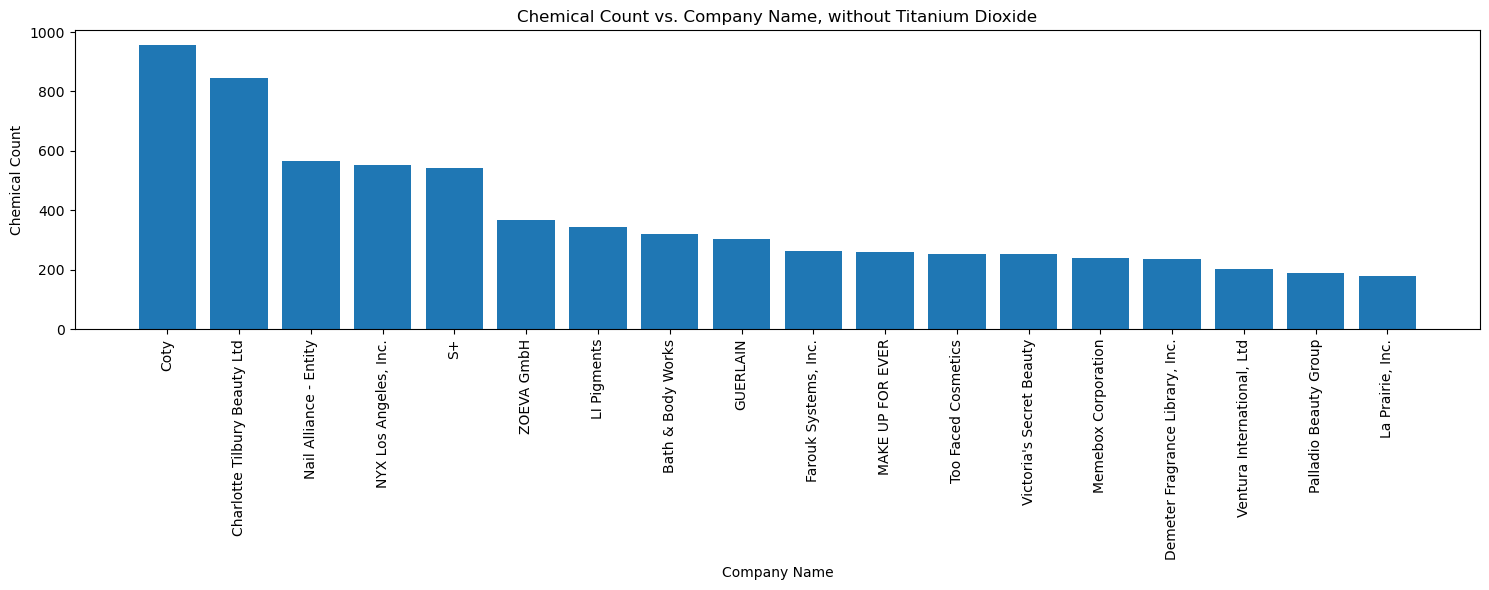

In [25]:
# Plotting the data
plt.figure(figsize=(15,6))

plt.bar(top20_rmv_titanuim_df["CompanyName"], top20_rmv_titanuim_df["ChemicalCount"])

plt.xlabel('Company Name')
plt.ylabel('Chemical Count')
plt.title('Chemical Count vs. Company Name, without Titanium Dioxide')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Graphs/graph3.png")

plt.show()

In [26]:
# Baby product analysis
baby_products_df = cosmetics_cleaned_df.loc[cosmetics_cleaned_df["PrimaryCategory"]=="Baby Products"]
baby_products_df = baby_products_df[["CompanyName", "PrimaryCategory", "ChemicalName","DiscontinuedDate", "ChemicalDateRemoved", "ChemicalCount"]]
baby_products_df.head()

,CompanyName,PrimaryCategory,ChemicalName,DiscontinuedDate,ChemicalDateRemoved,ChemicalCount
6604,"Farouk Systems, Inc.",Baby Products,Trade Secret,NaT,2009-10-13,0
12980,"Buth-na-Bodhaige, Inc",Baby Products,Cocamide DEA,2011-02-11,NaT,1
12981,"Buth-na-Bodhaige, Inc",Baby Products,Cocamide DEA,2011-02-11,NaT,1
14178,John Paul Mitchell Systems,Baby Products,Styrene,NaT,NaT,1
15001,LEVLAD LLC,Baby Products,Retinyl esters,2009-05-31,NaT,1


In [27]:
# Rename for readability
baby_products_df['ChemicalName'] = baby_products_df['ChemicalName'].replace({
    "Cadmium and cadmium compounds" : "Cadmium", 
    "Silica, crystalline (airborne particles of respirable size)" : "Silica", 
    "Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents." : "Daily dosages of Retinol/retinyl esters"})
baby_products_df.head()


,CompanyName,PrimaryCategory,ChemicalName,DiscontinuedDate,ChemicalDateRemoved,ChemicalCount
6604,"Farouk Systems, Inc.",Baby Products,Trade Secret,NaT,2009-10-13,0
12980,"Buth-na-Bodhaige, Inc",Baby Products,Cocamide DEA,2011-02-11,NaT,1
12981,"Buth-na-Bodhaige, Inc",Baby Products,Cocamide DEA,2011-02-11,NaT,1
14178,John Paul Mitchell Systems,Baby Products,Styrene,NaT,NaT,1
15001,LEVLAD LLC,Baby Products,Retinyl esters,2009-05-31,NaT,1


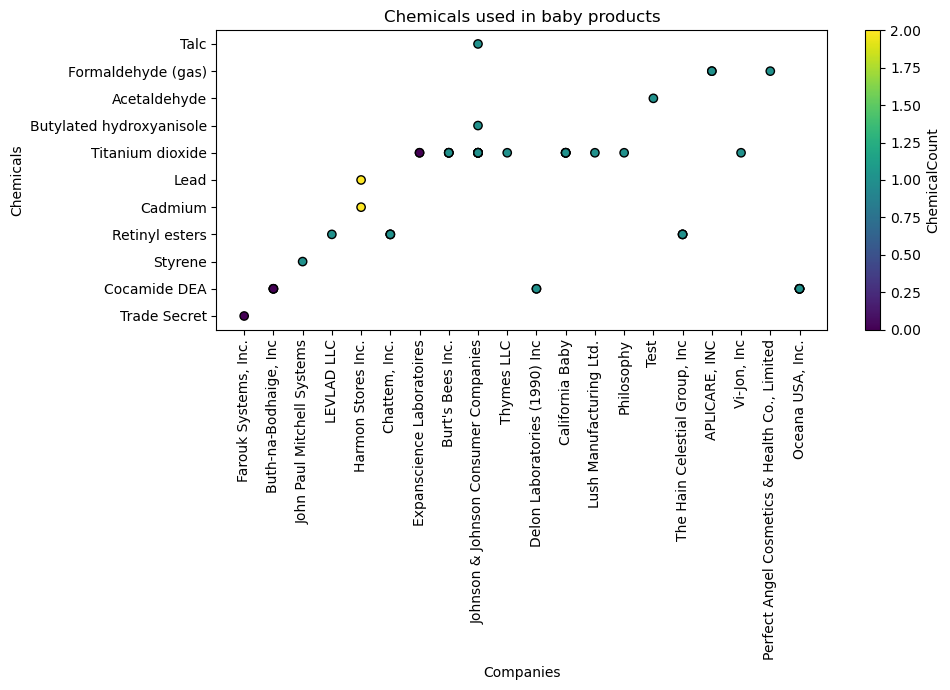

In [28]:
# Plotting the data
plt.figure(figsize=(10,7))
plt.scatter(baby_products_df["CompanyName"], baby_products_df["ChemicalName"], c=baby_products_df["ChemicalCount"], facecolors="red", edgecolors="black")

plt.xticks(rotation=90)
plt.xlabel("Companies")
plt.ylabel("Chemicals")
plt.title("Chemicals used in baby products")
clb = plt.colorbar()
clb.set_label("ChemicalCount")
plt.tight_layout()
plt.savefig("Graphs/graph4.png")
plt.show()

# 2. Which potentially hazardous chemicals have been reported the most?

In [29]:
# Extract chemical data and remove duplicates
chemical_data_df = cosmetics_cleaned_df[['ChemicalName', 'CasNumber']]
chemical_data_df.head()

,ChemicalName,CasNumber
0,Titanium dioxide,13463-67-7
1,Distillates (coal tar),65996-92-1
2,Estragole,140-67-0
3,Titanium dioxide,13463-67-7
4,Titanium dioxide,13463-67-7


In [30]:
# Count occurrences and get the top 10 chemicals
chemical_counts = chemical_data_df['ChemicalName'].value_counts()
top_10_chemicals = chemical_counts.head(10)
top_10_chemicals

ChemicalName
Titanium dioxide                                               87529
Retinyl esters                                                  3174
Silica, crystalline (airborne particles of respirable size)     2461
Mica                                                            1835
Talc                                                            1734
Carbon black                                                    1704
Cocamide DEA                                                    1595
Butylated hydroxyanisole                                        1301
Vitamin A palmitate                                              953
Mineral oils, untreated and mildly treated                       512
Name: count, dtype: int64

In [31]:
# Defining a function for shortening the names on the chart
def shorten_name(name):
    return name if len(name) <= 30 else name[:30] + '...'
shortened_labels = [shorten_name(name) for name in top_10_chemicals.index]

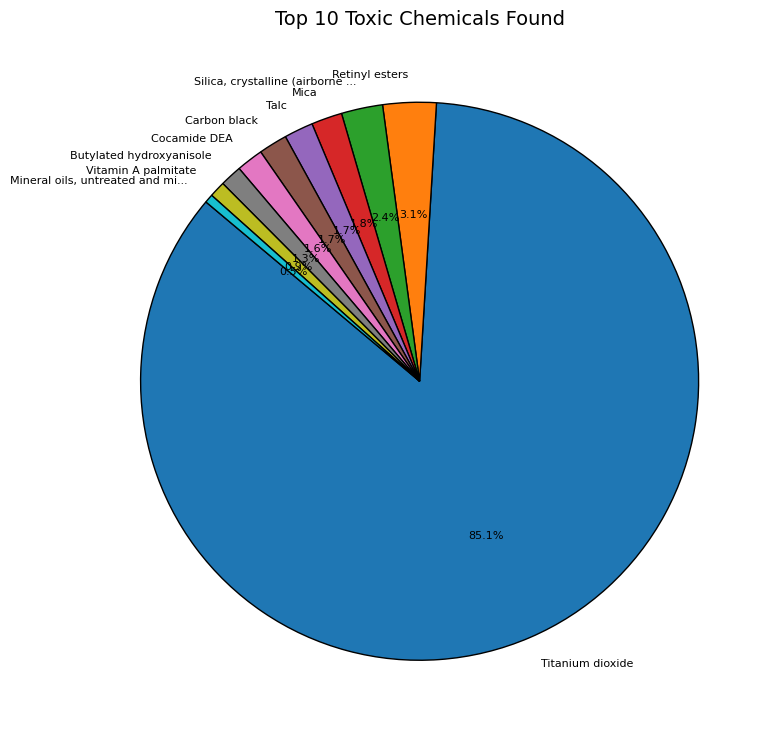

In [32]:
# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_10_chemicals.values, labels=shortened_labels, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 8}, wedgeprops={'edgecolor': 'black'})

# Set title and layout
plt.title('Top 10 Toxic Chemicals Found', fontsize=14)
plt.tight_layout()

plt.savefig("Graphs/graph5.png")

# Show chart
plt.show()

# 3. Which product categories contain the most reports of potentially hazardous chemicals?

In [33]:
# Group data by categories
categories_df = cosmetics_cleaned_df.groupby('PrimaryCategory')['ChemicalName'].nunique()
sorted_categories_df = categories_df.sort_values(ascending=False)
sorted_categories_df

PrimaryCategory
Skin Care Products                   78
Hair Care Products (non-coloring)    65
Makeup Products (non-permanent)      48
Bath Products                        39
Sun-Related Products                 38
Nail Products                        30
Personal Care Products               29
Hair Coloring Products               22
Fragrances                           21
Shaving Products                     17
Baby Products                        11
Oral Hygiene Products                 6
Tattoos and Permanent Makeup          4
Name: ChemicalName, dtype: int64

In [34]:
# Put the top 10 categories in their own set
top_10_categories = sorted_categories_df.head(10)
top_10_categories

PrimaryCategory
Skin Care Products                   78
Hair Care Products (non-coloring)    65
Makeup Products (non-permanent)      48
Bath Products                        39
Sun-Related Products                 38
Nail Products                        30
Personal Care Products               29
Hair Coloring Products               22
Fragrances                           21
Shaving Products                     17
Name: ChemicalName, dtype: int64

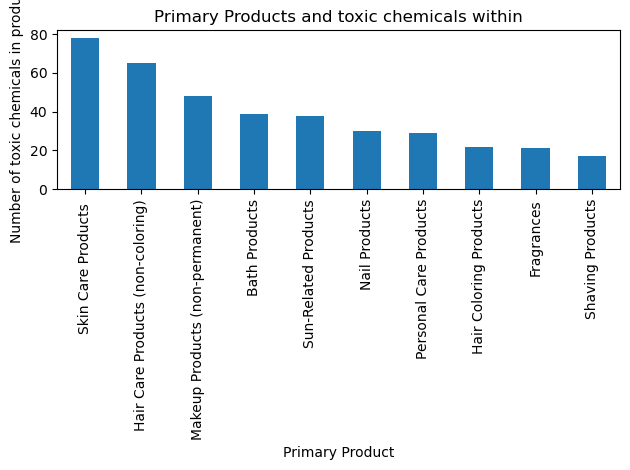

In [35]:
# Plotting the data
top_10_categories.plot(kind='bar') 
plt.title('Primary Products and toxic chemicals within')
plt.xlabel('Primary Product')
plt.ylabel("Number of toxic chemicals in products")
plt.tight_layout()
plt.savefig("Graphs/graph6.png")
plt.show()

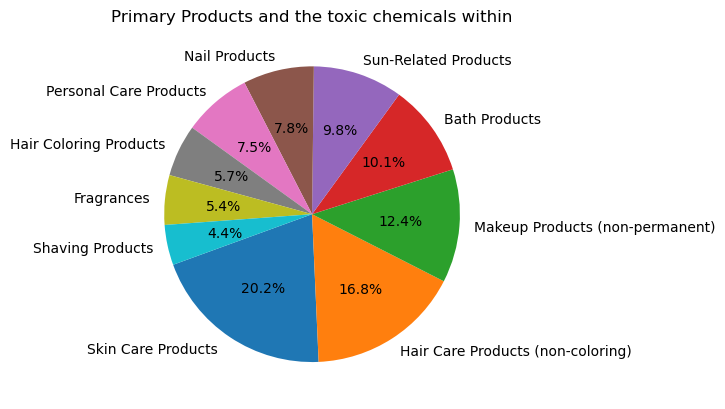

In [36]:
# Plotting the data
top_10_categories.plot(kind='pie', y='Number of toxic chemicals in products', autopct='%1.1f%%', startangle=200, legend=False)
plt.title('Primary Products and the toxic chemicals within')
plt.ylabel('')
plt.savefig("Graphs/graph7.png")
plt.show()

In [37]:
# Group data by categories
#subcategories_df = cosmetics_cleaned_df[['SubCategory','ChemicalName']]
#subcategories_df
subcategories_df = cosmetics_cleaned_df.groupby('SubCategory')['ChemicalName'].nunique()
sorted_subcategories_df = subcategories_df.sort_values(ascending=False)
sorted_subcategories_df

SubCategory
Skin Moisturizers (making a cosmetic claim)         49
Hair Shampoos (making a cosmetic claim)             42
Skin Cleansers                                      37
Facial Cream                                        37
Hair Styling Products                               36
                                                    ..
Lubricants  (e.g. personal, sexual, massage oil)     1
Hair Color Sprays (aerosol)                          1
Other Baby Products                                  1
Other Oral Hygiene Product                           1
Feminine Deodorants                                  1
Name: ChemicalName, Length: 89, dtype: int64

In [38]:
# Put the top 10 subcategories in their own set
top_10_subcategories = sorted_subcategories_df.head(10)
top_10_subcategories

SubCategory
Skin Moisturizers (making a cosmetic claim)                   49
Hair Shampoos (making a cosmetic claim)                       42
Skin Cleansers                                                37
Facial Cream                                                  37
Hair Styling Products                                         36
Sunscreen (making a cosmetic claim)                           34
Hair Conditioners (rinse-out)                                 31
Other Skin Care Product                                       29
Anti-Wrinkle/Anti-Aging Products (making a cosmetic claim)    29
Body Washes and Soaps                                         27
Name: ChemicalName, dtype: int64

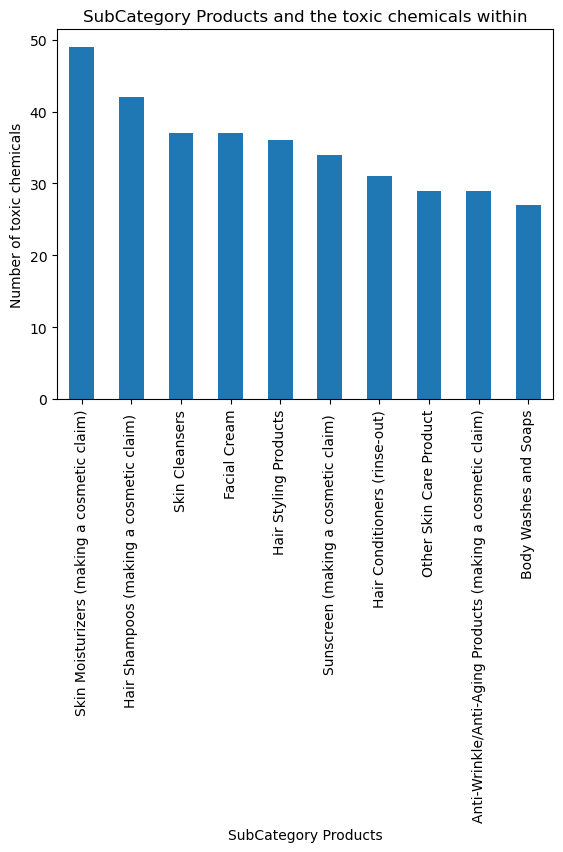

In [39]:
# Plotting the data
top_10_subcategories.plot(kind='bar')
plt.title('SubCategory Products and the toxic chemicals within')
plt.xlabel('SubCategory Products')
plt.ylabel("Number of toxic chemicals")
plt.tight_layout()
plt.savefig("Graphs/graph8.png")
plt.show()

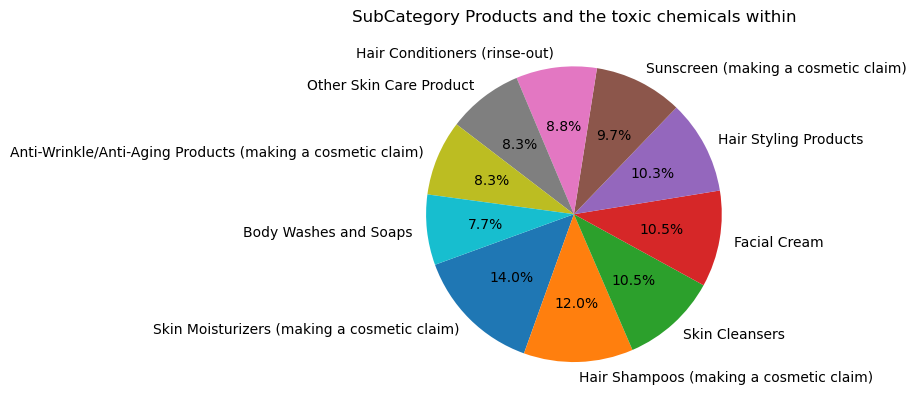

In [40]:
# Plotting the data
top_10_subcategories.plot(kind='pie', autopct='%1.1f%%', startangle=200, legend=False)
plt.title('SubCategory Products and the toxic chemicals within')
plt.ylabel('')
plt.savefig("Graphs/graph9.png")
plt.show()

# 4. What kind of changes were there in the reporting of potentially hazardous chemicals from year to year?

In [41]:
# Extract the year from the date columns
cosmetics_cleaned_df['YearReported'] = cosmetics_cleaned_df['InitialDateReported'].dt.year
cosmetics_cleaned_df['YearCreated'] = cosmetics_cleaned_df['ChemicalCreatedAt'].dt.year
cosmetics_cleaned_df['YearMostRecent'] = cosmetics_cleaned_df['MostRecentDateReported'].dt.year
cosmetics_cleaned_df.head(1)

,ProductName,CSF,CompanyName,BrandName,PrimaryCategory,SubCategory,CasNumber,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount,YearReported,YearCreated,YearMostRecent
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,New Avon LLC,AVON,Makeup Products (non-permanent),"Lip Color - Lipsticks, Liners, and Pencils",13463-67-7,Titanium dioxide,2009-06-17,2013-08-28,2011-02-01,2009-07-09,2009-07-09,NaT,1,2009,2009,2013


In [42]:
# Count the number of reports for each year
yearly_report_count = cosmetics_cleaned_df['YearReported'].value_counts().sort_index()

# Convert to a DataFrame for easier plotting
yearly_report_df = yearly_report_count.reset_index()
yearly_report_df.columns = ['Year', 'ReportCount']

# Exclude 2020 from the data
yearly_report_df = yearly_report_df[yearly_report_df['Year'] < 2020]
yearly_report_df

,Year,ReportCount
0,2009,28134
1,2010,13684
2,2011,4173
3,2012,3594
4,2013,6130
5,2014,8258
6,2015,7610
7,2016,4408
8,2017,6992
9,2018,9248


In [43]:
# Filter the dataset for reports of titanium dioxide
titanium_dioxide_df = cosmetics_cleaned_df[cosmetics_cleaned_df['ChemicalName'].str.contains("Titanium dioxide", case=False, na=False)]
titanium_dioxide_df.head(1)

,ProductName,CSF,CompanyName,BrandName,PrimaryCategory,SubCategory,CasNumber,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount,YearReported,YearCreated,YearMostRecent
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,New Avon LLC,AVON,Makeup Products (non-permanent),"Lip Color - Lipsticks, Liners, and Pencils",13463-67-7,Titanium dioxide,2009-06-17,2013-08-28,2011-02-01,2009-07-09,2009-07-09,NaT,1,2009,2009,2013


In [44]:
# Count the number of titanium dioxide reports for each year
yearly_titanium_dioxide_count = titanium_dioxide_df['YearReported'].value_counts().sort_index()

# Convert to a DataFrame for easier plotting
yearly_titanium_dioxide_df = yearly_titanium_dioxide_count.reset_index()
yearly_titanium_dioxide_df.columns = ['Year', 'ReportCount']

# Exclude 2020 from the data
yearly_titanium_dioxide_df = yearly_titanium_dioxide_df[yearly_titanium_dioxide_df['Year'] < 2020]
yearly_titanium_dioxide_df

,Year,ReportCount
0,2009,23639
1,2010,11174
2,2011,3365
3,2012,2971
4,2013,4553
5,2014,7473
6,2015,6449
7,2016,3985
8,2017,5236
9,2018,7318


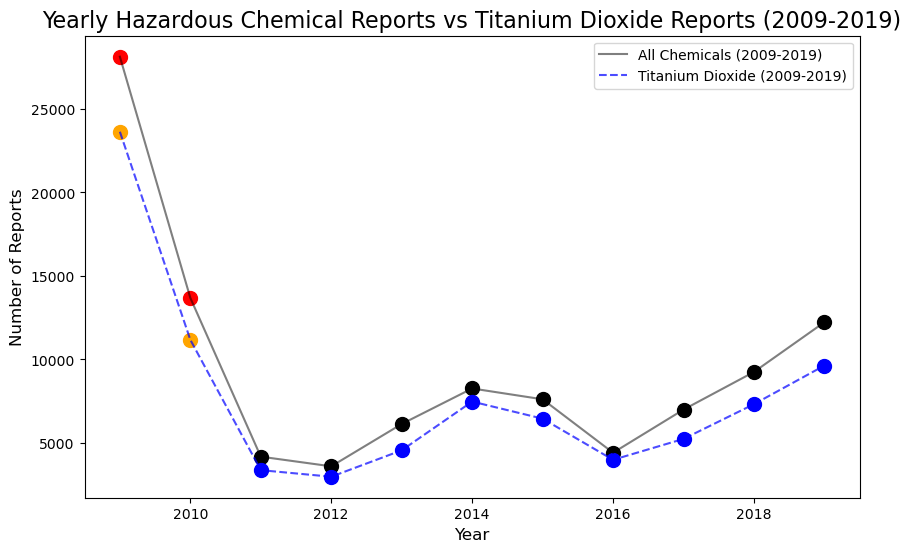

In [45]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot the line for all chemicals from 2009 to 2019 in light black (gray)
plt.plot(yearly_report_df['Year'], 
         yearly_report_df['ReportCount'], 
         color='black', alpha=0.5, label='All Chemicals (2009-2019)')

# Add large black circle markers for the years 2011-2019 for all chemicals
plt.scatter(yearly_report_df[yearly_report_df['Year'] > 2010]['Year'], 
            yearly_report_df[yearly_report_df['Year'] > 2010]['ReportCount'], 
            s=100, color='black')

# Add red circle markers for the years 2009-2010 for all chemicals
plt.scatter(yearly_report_df[yearly_report_df['Year'].isin([2009, 2010])]['Year'], 
            yearly_report_df[yearly_report_df['Year'].isin([2009, 2010])]['ReportCount'], 
            s=100, color='red')

# Plot the line for titanium dioxide from 2009 to 2019 in blue
plt.plot(yearly_titanium_dioxide_df['Year'], 
         yearly_titanium_dioxide_df['ReportCount'], 
         color='blue', alpha=0.7, label='Titanium Dioxide (2009-2019)', linestyle='--')

# Add blue circle markers for the years 2011-2019 for titanium dioxide
plt.scatter(yearly_titanium_dioxide_df[yearly_titanium_dioxide_df['Year'] > 2010]['Year'], 
            yearly_titanium_dioxide_df[yearly_titanium_dioxide_df['Year'] > 2010]['ReportCount'], 
            s=100, color='blue')

# Add orange circle markers for the years 2009-2010 for titanium dioxide
plt.scatter(yearly_titanium_dioxide_df[yearly_titanium_dioxide_df['Year'].isin([2009, 2010])]['Year'], 
            yearly_titanium_dioxide_df[yearly_titanium_dioxide_df['Year'].isin([2009, 2010])]['ReportCount'], 
            s=100, color='orange')

# Labels and Title
plt.title('Yearly Hazardous Chemical Reports vs Titanium Dioxide Reports (2009-2019)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reports', fontsize=12)

# Add a legend
plt.legend()

plt.savefig("Graphs/graph10.png")

# Display the plot
plt.show()

In [46]:
# Filter data for L'Oreal USA reports
loreal_df = cosmetics_cleaned_df[cosmetics_cleaned_df['CompanyName'] == "L'Oreal USA"]

# Count L'Oréal USA reports by year, excluding 2009 and 2020
loreal_yearly_report_count = loreal_df['YearReported'].value_counts().sort_index()
loreal_yearly_report_df = loreal_yearly_report_count.reset_index()
loreal_yearly_report_df.columns = ['Year', 'ReportCount']
loreal_yearly_report_df = loreal_yearly_report_df[(loreal_yearly_report_df['Year'] > 2009) & (loreal_yearly_report_df['Year'] < 2020)]
loreal_yearly_report_df

,Year,ReportCount
1,2010,505
2,2011,425
3,2012,440
4,2013,356
5,2014,344
6,2015,18
7,2016,10
8,2017,1
9,2019,2


In [47]:
# Filter data for L'Oreal USA and Titanium Dioxide reports
loreal_titanium_df = loreal_df[loreal_df['ChemicalName'] == 'Titanium dioxide']

# Count L'Oréal USA Titanium Dioxide reports by year, excluding 2009 and 2020
loreal_titanium_yearly_report_count = loreal_titanium_df['YearReported'].value_counts().sort_index()
loreal_titanium_yearly_report_df = loreal_titanium_yearly_report_count.reset_index()
loreal_titanium_yearly_report_df.columns = ['Year', 'ReportCount']
loreal_titanium_yearly_report_df = loreal_titanium_yearly_report_df[(loreal_titanium_yearly_report_df['Year'] > 2009) & (loreal_titanium_yearly_report_df['Year'] < 2020)]
loreal_titanium_yearly_report_df

,Year,ReportCount
1,2010,505
2,2011,421
3,2012,440
4,2013,356
5,2014,344
6,2015,18
7,2016,10
8,2017,1
9,2019,2


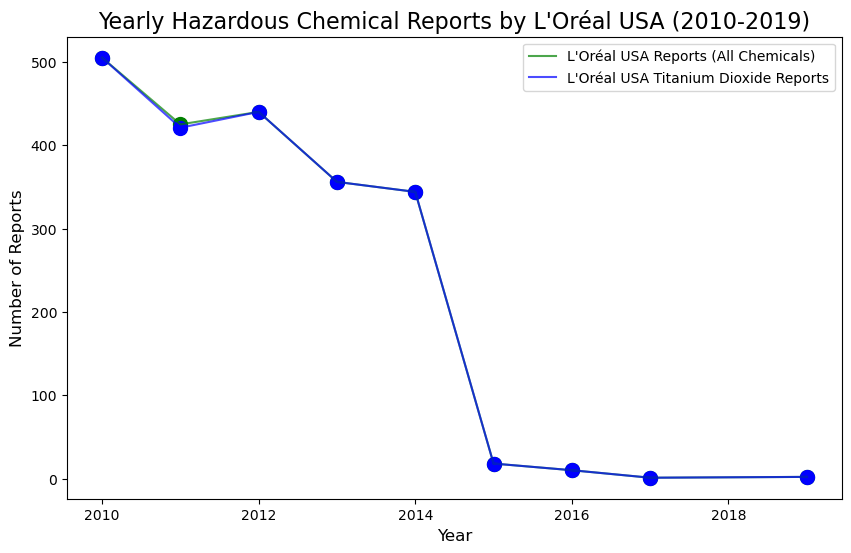

In [48]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot the line for L'Oréal USA reports (all chemicals)
plt.plot(loreal_yearly_report_df['Year'], 
         loreal_yearly_report_df['ReportCount'], 
         color='green', alpha=0.7, label='L\'Oréal USA Reports (All Chemicals)')

# Add large circle markers for L'Oréal USA reports by year
plt.scatter(loreal_yearly_report_df['Year'], 
            loreal_yearly_report_df['ReportCount'], 
            s=100, color='green')

# Plot the line for L'Oréal USA Titanium Dioxide reports
plt.plot(loreal_titanium_yearly_report_df['Year'], 
         loreal_titanium_yearly_report_df['ReportCount'], 
         color='blue', alpha=0.7, label='L\'Oréal USA Titanium Dioxide Reports')

# Add large circle markers for L'Oréal USA Titanium Dioxide reports by year
plt.scatter(loreal_titanium_yearly_report_df['Year'], 
            loreal_titanium_yearly_report_df['ReportCount'], 
            s=100, color='blue')

# Labels and Title
plt.title('Yearly Hazardous Chemical Reports by L\'Oréal USA (2010-2019)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reports', fontsize=12)
plt.legend()

plt.savefig("Graphs/graph11.png")

# Display the plot
plt.show()

In [49]:
# Filter rows where a DiscontinuedDate is present (i.e., a chemical was discontinued)
discontinued_df = cosmetics_cleaned_df[cosmetics_cleaned_df['DiscontinuedDate'].notna()]

# Group by 'Company' and count the number of discontinued reports for each company
discontinuations_by_company = discontinued_df.groupby('CompanyName').size().reset_index(name='DiscontinuationCount')

# Sort the DataFrame by the number of discontinuations in descending order
discontinuations_by_company = discontinuations_by_company.sort_values(by='DiscontinuationCount', ascending=False)

# Put the top 10 companies into a DataFrame
top_10_discontinuations = discontinuations_by_company.head(10)
top_10_discontinuations

,CompanyName,DiscontinuationCount
165,The Procter & Gamble Company,2778
177,Victoria's Secret Beauty,924
51,"Elizabeth Arden, Inc.",720
93,MAESA LLC,643
24,"Buth-na-Bodhaige, Inc",549
15,Bath & Body Works,525
58,GUERLAIN,468
162,The Boots Company PLC,395
115,New Avon LLC,363
43,Cover FX Skin Care Inc.,351


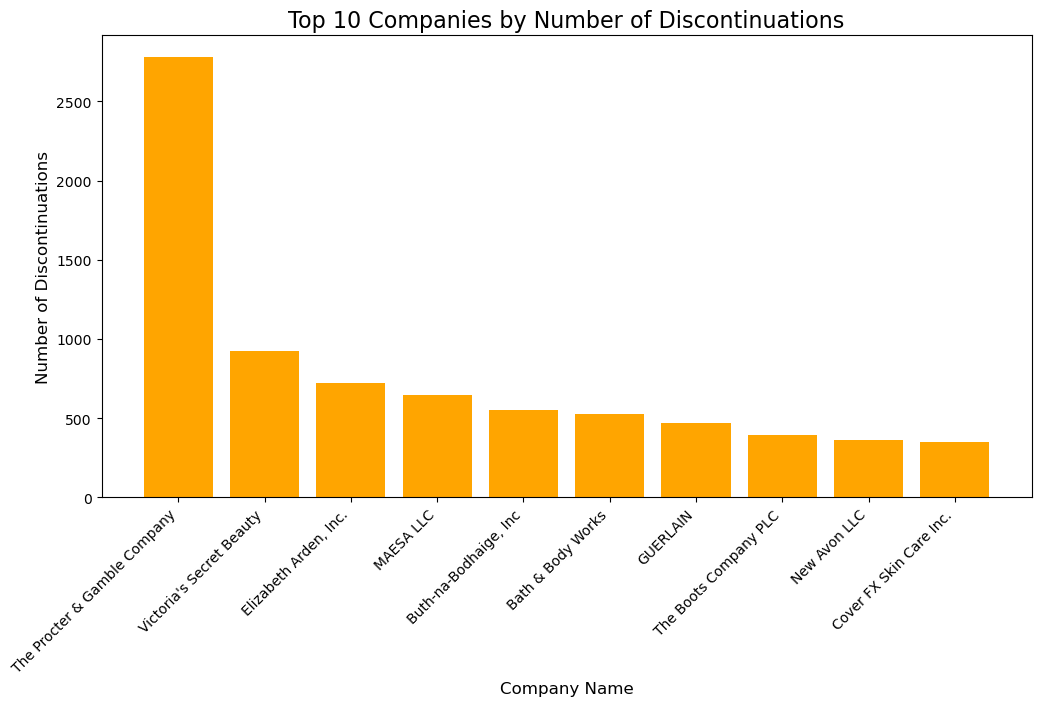

In [50]:
# Plotting the data
plt.figure(figsize=(12, 6))

# Create a bar graph for the top 10 companies
plt.bar(top_10_discontinuations['CompanyName'], 
        top_10_discontinuations['DiscontinuationCount'], 
        color='orange')

# Labels and Title
plt.title('Top 10 Companies by Number of Discontinuations', fontsize=16)
plt.xlabel('Company Name', fontsize=12)
plt.ylabel('Number of Discontinuations', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.savefig("Graphs/graph12.png")

# Display the plot
plt.show()

In [51]:
# Filter the DataFrame for discontinued chemicals
discontinued_chemicals_df = cosmetics_cleaned_df[cosmetics_cleaned_df['DiscontinuedDate'].notnull()]

# Count the number of discontinuations for each chemical
discontinuation_counts = discontinued_chemicals_df['ChemicalName'].value_counts()

# Convert to a DataFrame for better presentation
discontinuation_counts_df = discontinuation_counts.reset_index()
discontinuation_counts_df.columns = ['ChemicalName', 'DiscontinuationCount']

discontinuation_counts_df.head(20)

,ChemicalName,DiscontinuationCount
0,Titanium dioxide,9711
1,Retinyl esters,678
2,Mica,394
3,Cocamide DEA,376
4,Butylated hydroxyanisole,178
5,"Mineral oils, untreated and mildly treated",160
6,"Silica, crystalline (airborne particles of res...",94
7,Carbon black,82
8,Talc,79
9,Benzophenone,37


In [52]:
# Count the number of reports for each chemical
report_counts = cosmetics_cleaned_df['ChemicalName'].value_counts()

# Convert to a DataFrame for better presentation
report_counts_df = report_counts.reset_index()
report_counts_df.columns = ['ChemicalName', 'ReportCount']

report_counts_df.head(20)

,ChemicalName,ReportCount
0,Titanium dioxide,87529
1,Retinyl esters,3174
2,"Silica, crystalline (airborne particles of res...",2461
3,Mica,1835
4,Talc,1734
5,Carbon black,1704
6,Cocamide DEA,1595
7,Butylated hydroxyanisole,1301
8,Vitamin A palmitate,953
9,"Mineral oils, untreated and mildly treated",512


In [53]:
# Merge the two DataFrames on ChemicalName
merged_df = pd.merge(report_counts_df, discontinuation_counts_df, on='ChemicalName', how='left')

# Fill NaN values in TotalDiscontinuations with 0
merged_df['DiscontinuationCount'] = merged_df['DiscontinuationCount'].fillna(0)

# Calculate the percentage of discontinuations
merged_df['DiscontinuationPercentage'] = (merged_df['DiscontinuationCount'] / merged_df['ReportCount']) * 100

merged_df

,ChemicalName,ReportCount,DiscontinuationCount,DiscontinuationPercentage
0,Titanium dioxide,87529,9711.0,11.094609
1,Retinyl esters,3174,678.0,21.361059
2,"Silica, crystalline (airborne particles of res...",2461,94.0,3.819586
3,Mica,1835,394.0,21.471390
4,Talc,1734,79.0,4.555940
...,...,...,...,...
111,Acetylsalicylic acid,1,0.0,0.000000
112,2-Propyleneacrolein,1,0.0,0.000000
113,Spironolactone,1,1.0,100.000000
114,Extract of coffee bean,1,0.0,0.000000


In [54]:
# Filter to include only chemicals reported at least 100 times
filtered_df = merged_df[merged_df['ReportCount'] >= 100]

# Calculate the percentage of discontinuations
filtered_df['DiscontinuationPercentage'] = (filtered_df['DiscontinuationCount'] / filtered_df['ReportCount']) * 100

# Filter to include only percentages above 10%
filtered_above_10_percent = filtered_df[filtered_df['DiscontinuationPercentage'] > 10]

# Sort the DataFrame by DiscontinuationPercentage from highest to lowest
percent_sorted_df = filtered_above_10_percent.sort_values(by='DiscontinuationPercentage', ascending=False)

percent_sorted_df

,ChemicalName,ReportCount,DiscontinuationCount,DiscontinuationPercentage
9,"Mineral oils, untreated and mildly treated",512,160.0,31.250000
6,Cocamide DEA,1595,376.0,23.573668
3,Mica,1835,394.0,21.471390
1,Retinyl esters,3174,678.0,21.361059
17,Methyleugenol,150,32.0,21.333333
16,Estragole,154,26.0,16.883117
14,Benzophenone,231,37.0,16.017316
19,Formaldehyde (gas),139,22.0,15.827338
7,Butylated hydroxyanisole,1301,178.0,13.681783
20,Cocamide MEA,116,15.0,12.931034


In [55]:
# Create a new DataFrame with only ChemicalName and DiscontinuationPercentage
chemical_discontinuation_percentage_df = percent_sorted_df[['ChemicalName', 'DiscontinuationPercentage']]

# Display the new DataFrame
chemical_discontinuation_percentage_df

,ChemicalName,DiscontinuationPercentage
9,"Mineral oils, untreated and mildly treated",31.250000
6,Cocamide DEA,23.573668
3,Mica,21.471390
1,Retinyl esters,21.361059
17,Methyleugenol,21.333333
16,Estragole,16.883117
14,Benzophenone,16.017316
19,Formaldehyde (gas),15.827338
7,Butylated hydroxyanisole,13.681783
20,Cocamide MEA,12.931034


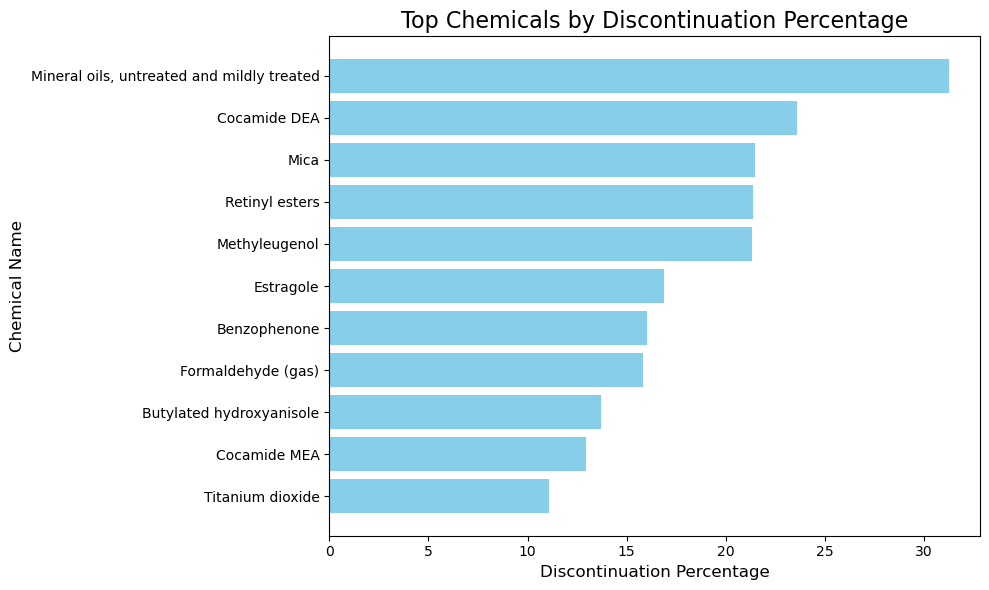

In [56]:
# Plot a bar graph for the top chemicals by discontinuation percentage
plt.figure(figsize=(10, 6))

# Create the bar plot
plt.barh(chemical_discontinuation_percentage_df['ChemicalName'], 
         chemical_discontinuation_percentage_df['DiscontinuationPercentage'], 
         color='skyblue')

# Add labels and title
plt.xlabel('Discontinuation Percentage', fontsize=12)
plt.ylabel('Chemical Name', fontsize=12)
plt.title('Top Chemicals by Discontinuation Percentage', fontsize=16)

# Invert y-axis so highest values are at the top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()

plt.savefig("Graphs/graph13.png")

plt.show()